In [ ]:
import yfinance as yf
import tensorflow
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
plt.style.use('ggplot')
palette = 'husl'
sns.set_palette(palette)
from scipy.optimize import minimize
import logging
np.object = object
!pip install keras-tuner -q
import holidays
import pandas_datareader.data as web # for FRED data
from datetime import datetime

# Set constants
START_DATE = '2005-12-31'
END_DATE = '2023-12-29'
TICKERS = ['AGG', 'DBC', 'VTI', 'VNQ', 'FXE'] # Add more assets, model 1 talks about stock selection
FRED_TICKERS_DICT = {
    'DCOILWTICO': 'wti',  # https://fred.stlouisfed.org/series/DCOILWTICO/
    'T5YIE': 'inflation5y',  # https://fred.stlouisfed.org/series/T5YIE
    'DGS10': 'treasury10y',  # https://fred.stlouisfed.org/series/DGS10
    'VIXCLS': 'vix',  # https://fred.stlouisfed.org/series/VIXCLS/
    'BAMLH0A0HYM2': 'credit_spreads',  # https://fred.stlouisfed.org/series/BAMLH0A0HYM2/
    'FEDFUNDS': 'fedfunds' # Monthly, will be filled forward https://fred.stlouisfed.org/series/fedfunds
}

TRAIN_TEST_SPLIT = 0.80

# Data range is used as an example hear  to show how we extract data
history = {ticker: yf.Ticker(ticker).history(start=START_DATE, end=END_DATE) for ticker in TICKERS}


#Data range is used as an example hear  to show how we extract data
#tickers = ['AGG', 'DBC', 'VTI', 'VNQ', "FXE"]
#fields = ['Open', 'Volume']
#history = yf.download(tickers)[fields].dropna()
history

{'AGG':                                 Open       High        Low      Close  \
 Date                                                                    
 2006-01-03 00:00:00-05:00  57.642187  57.785618  57.579077  57.739719   
 2006-01-04 00:00:00-05:00  57.768448  57.877453  57.722549  57.877453   
 2006-01-05 00:00:00-05:00  57.843031  57.894668  57.722549  57.877453   
 2006-01-06 00:00:00-05:00  57.877423  57.883161  57.716780  57.745468   
 2006-01-09 00:00:00-05:00  57.797117  57.883177  57.716796  57.808594   
 ...                              ...        ...        ...        ...   
 2023-12-21 00:00:00-05:00  98.633718  98.673482  98.246023  98.375252   
 2023-12-22 00:00:00-05:00  98.544256  98.554199  98.226147  98.246033   
 2023-12-26 00:00:00-05:00  98.345432  98.494547  98.305667  98.444839   
 2023-12-27 00:00:00-05:00  98.812663  99.110886  98.723191  99.071129   
 2023-12-28 00:00:00-05:00  98.951832  99.061183  98.723188  98.852425   
 
                             

In [ ]:
class Preprocessing_v2:
    def __init__(self, tickers: list = TICKERS, time_step: int = 30,
                 start_date: str = START_DATE, end_date: str = END_DATE,
                 train_test_split: float = 0.8,
                 return_horizon: int = 1,  # 1-day returns
                 asset_features: list = ['Close', 'Volume'],
                 features_in_returns: list = ['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
                 features_in_level_diffs: list = ['inflation5y', 'treasury10y', 'vix', 'credit_spreads'],
                 target_col: str = 'Close',
                 add_external_data: bool = True,
                 keep_weekly_only: bool = False,
                 explanatory_tickers: dict = FRED_TICKERS_DICT):
        self.tickers = tickers
        self.time_step = time_step
        self.start_date = start_date
        self.end_date = end_date
        self.train_test_split = train_test_split
        self.add_external_data = add_external_data
        self.keep_weekly_only = keep_weekly_only
        self.raw_history = {}
        self.return_horizon = return_horizon
        self.asset_features = asset_features
        self.features_in_returns = features_in_returns
        self.features_in_level_diffs = features_in_level_diffs
        self.target_col = target_col
        self.explanatory_tickers = explanatory_tickers

        self.history_train_df = pd.DataFrame()
        self.history_test_df = pd.DataFrame()
        self.risk_free_train = pd.DataFrame()
        self.risk_free_test = pd.DataFrame()
        self.x_train = np.array([])
        self.y_train = np.array([])
        self.x_scaler_train = None
        self.y_scaler_train = None
        self.x_test = np.array([])
        self.y_test = np.array([])
        self.x_scaler_test = None
        self.y_scaler_test = None

    def _import_data(self):
        logging.info('Importing data from Yahoo...')
        self.raw_history = {ticker: yf.Ticker(ticker).history(start=self.start_date, end=self.end_date)
                            for ticker in self.tickers}

    def import_fred_data(self):
        """
        Import economic data from FRED.
        Remove weekends and holidays. Forward fill NAs, useful for instance
        with FedFunds available monthly
        """
        start = datetime.strptime(START_DATE, '%Y-%m-%d')
        end = datetime.strptime(END_DATE, '%Y-%m-%d')
        external_data = web.DataReader(list(self.explanatory_tickers.keys()), "fred", start, end)
        external_data = external_data.rename(columns=self.explanatory_tickers)

        us_holidays = holidays.UnitedStates()
        holiday_filter = [dt not in us_holidays for dt in external_data.index.date]
        external_data = external_data[(external_data.index.weekday < 5)&(holiday_filter)]
        external_data = external_data.fillna(method='ffill').dropna()

        for col in external_data.columns.values:
            if any(x in col for x in self.features_in_returns):
                external_data[col] = np.log(external_data[col]) - np.log(external_data[col].shift(
                    self.return_horizon))
            if any(x in col for x in self.features_in_level_diffs):
                external_data[col] = external_data[col] - external_data[col].shift(
                    self.return_horizon)

        return external_data

    def _preprocess_data(self, history_data, tickers):
        """
        Place all the input data into one data frame. Add log returns
        where the field should be defined in returns. Fill in nulls.
        """
        feat_df = []
        for ticker in tickers:
            ticker_df = history_data[ticker][self.asset_features].copy()
            names_dict = dict(zip(self.asset_features, [f'{ticker}_{ft}' for ft in self.asset_features]))
            ticker_df.rename(columns=names_dict, inplace=True)
            feat_df.append(ticker_df)

        feat_df = pd.concat(feat_df, axis=1)
        feat_df = feat_df.fillna(method='ffill')

        feat_df_incl_ret = feat_df.copy()

        for col in feat_df.columns.values:
            if any(x in col for x in self.features_in_returns) and any(x not in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = np.log(feat_df_incl_ret[col]) - np.log(feat_df_incl_ret[col].shift(
                    self.return_horizon))
            elif any(x in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = feat_df_incl_ret[col] - feat_df_incl_ret[col].shift(
                    self.return_horizon)

        feat_df_incl_ret.dropna(inplace=True)

        feat_df_incl_ret.reset_index(drop=False, inplace=True)
        feat_df_incl_ret['Date'] = pd.to_datetime(feat_df_incl_ret['Date']).dt.date
        feat_df_incl_ret.set_index('Date', inplace=True)

        return feat_df_incl_ret

    def create_x_y_sequences(self, data_df, lookback):
        """
        Creates input sequences for a time series data with a specified lookback window.
        Assumes that y (target) is one of the columns in data_df.
        Transform the data into sequence of lookback length to predict one step forward (y).
        """
        sequences = []
        targets = []
        target_cols = [col for col in data_df.columns.values if self.target_col in col]

        y_data = data_df[target_cols].values
        x_data = data_df.values

        x_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))

        x_data = x_scaler.fit_transform(x_data)
        y_data = y_scaler.fit_transform(y_data)

        for i in range(len(data_df) - lookback):
            x_sequence = x_data[i: i + lookback]
            y_target = y_data[i + lookback]
            sequences.append(x_sequence)
            targets.append(y_target)

        return np.array(sequences), np.array(targets), x_scaler, y_scaler

    def run(self):
        """
        Source data if it has not been sourced.
        Split the data into train and test, and standardise.
        Clean and prepare data in the sequence format needed for modelling.
        """
        history_train = {}
        history_test = {}

        if len(self.raw_history) == 0:
            self._import_data()

        # Train Test split
        for ticker, data in self.raw_history.items():
            train_size = int(len(data) * self.train_test_split)
            history_train[ticker], history_test[ticker] = data[:train_size], data[train_size:]

        history_train_clean = self._preprocess_data(history_train, self.tickers)
        history_test_clean = self._preprocess_data(history_test, self.tickers)

        self.history_train_df = history_train_clean
        self.history_test_df = history_test_clean

        # Join with FRED macro data
        if self.add_external_data:
            fred_df = self.import_fred_data()
            self.history_test_df = self.history_test_df.join(fred_df, how='inner').fillna(method='ffill').dropna()
            self.history_train_df = self.history_train_df.join(fred_df, how='inner').fillna(method='ffill').dropna()

            self.risk_free_train = pd.DataFrame(self.history_train_df['fedfunds'][self.time_step:])
            self.risk_free_test = pd.DataFrame(self.history_test_df['fedfunds'][self.time_step:])

        if self.keep_weekly_only:
            self.history_test_df = self.history_test_df[(self.history_test_df.index.weekday == 4)]
            self.history_train_df = self.history_train_df[(self.history_train_df.index.weekday == 4)]

            if self.add_external_data:
                self.risk_free_train = self.risk_free_train[(self.risk_free_train.index.weekday == 4)]
                self.risk_free_test = self.risk_free_test[(self.risk_free_test.index.weekday == 4)]
        # Prepare modelling sequences of train and test
        self.x_train, self.y_train, self.x_scaler_train, self.y_scaler_train = self.create_x_y_sequences(
            self.history_train_df, self.time_step)
        self.x_test, self.y_test, self.x_scaler_test, self.y_scaler_test = self.create_x_y_sequences(
            self.history_test_df, self.time_step)

        data_struct = {
            'x_train': self.x_train,
            'y_train': self.y_train,
            'x_test': self.x_test,
            'y_test': self.y_test,

            'x_scaler_train': self.x_scaler_train,
            'y_scaler_train': self.y_scaler_train,
            'x_scaler_test': self.x_scaler_test,
            'y_scaler_test': self.y_scaler_test
        }
        return data_struct


In [ ]:
class Preprocessing_v2:
    def __init__(self, tickers: list = TICKERS, time_step: int = 30,
                 start_date: str = START_DATE, end_date: str = END_DATE,
                 train_test_split: float = 0.8,
                 return_horizon: int = 1,  # 1-day returns
                 asset_features: list = ['Close', 'Volume'],
                 features_in_returns: list = ['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
                 features_in_level_diffs: list = ['inflation5y', 'treasury10y', 'vix', 'credit_spreads'],
                 target_col: str = 'Close',
                 add_external_data: bool = True,
                 keep_weekly_only: bool = False,
                 explanatory_tickers: dict = FRED_TICKERS_DICT):
        self.tickers = tickers
        self.time_step = time_step
        self.start_date = start_date
        self.end_date = end_date
        self.train_test_split = train_test_split
        self.add_external_data = add_external_data
        self.keep_weekly_only = keep_weekly_only
        self.raw_history = {}
        self.return_horizon = return_horizon
        self.asset_features = asset_features
        self.features_in_returns = features_in_returns
        self.features_in_level_diffs = features_in_level_diffs
        self.target_col = target_col
        self.explanatory_tickers = explanatory_tickers

        self.history_train_df = pd.DataFrame()
        self.history_test_df = pd.DataFrame()
        self.risk_free_train = pd.DataFrame()
        self.risk_free_test = pd.DataFrame()
        self.x_train = np.array([])
        self.y_train = np.array([])
        self.x_scaler_train = None
        self.y_scaler_train = None
        self.x_test = np.array([])
        self.y_test = np.array([])
        self.x_scaler_test = None
        self.y_scaler_test = None

    def _import_data(self):
        logging.info('Importing data from Yahoo...')
        self.raw_history = {ticker: yf.Ticker(ticker).history(start=self.start_date, end=self.end_date)
                            for ticker in self.tickers}

    def import_fred_data(self):
        """
        Import economic data from FRED.
        Remove weekends and holidays. Forward fill NAs, useful for instance
        with FedFunds available monthly
        """
        start = datetime.strptime(START_DATE, '%Y-%m-%d')
        end = datetime.strptime(END_DATE, '%Y-%m-%d')
        external_data = web.DataReader(list(self.explanatory_tickers.keys()), "fred", start, end)
        external_data = external_data.rename(columns=self.explanatory_tickers)

        us_holidays = holidays.UnitedStates()
        holiday_filter = [dt not in us_holidays for dt in external_data.index.date]
        external_data = external_data[(external_data.index.weekday < 5)&(holiday_filter)]
        external_data = external_data.fillna(method='ffill').dropna()

        for col in external_data.columns.values:
            if any(x in col for x in self.features_in_returns):
                external_data[col] = np.log(external_data[col]) - np.log(external_data[col].shift(
                    self.return_horizon))
            if any(x in col for x in self.features_in_level_diffs):
                external_data[col] = external_data[col] - external_data[col].shift(
                    self.return_horizon)

        return external_data

    def _preprocess_data(self, history_data, tickers):
        """
        Place all the input data into one data frame. Add log returns
        where the field should be defined in returns. Fill in nulls.
        """
        feat_df = []
        for ticker in tickers:
            ticker_df = history_data[ticker][self.asset_features].copy()
            names_dict = dict(zip(self.asset_features, [f'{ticker}_{ft}' for ft in self.asset_features]))
            ticker_df.rename(columns=names_dict, inplace=True)
            feat_df.append(ticker_df)

        feat_df = pd.concat(feat_df, axis=1)
        feat_df = feat_df.fillna(method='ffill')

        feat_df_incl_ret = feat_df.copy()

        for col in feat_df.columns.values:
            if any(x in col for x in self.features_in_returns) and any(x not in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = np.log(feat_df_incl_ret[col]) - np.log(feat_df_incl_ret[col].shift(
                    self.return_horizon))
            elif any(x in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = feat_df_incl_ret[col] - feat_df_incl_ret[col].shift(
                    self.return_horizon)

        feat_df_incl_ret.dropna(inplace=True)

        feat_df_incl_ret.reset_index(drop=False, inplace=True)
        feat_df_incl_ret['Date'] = pd.to_datetime(feat_df_incl_ret['Date']).dt.date
        feat_df_incl_ret.set_index('Date', inplace=True)

        return feat_df_incl_ret

    def create_x_y_sequences(self, data_df, lookback):
        """
        Creates input sequences for a time series data with a specified lookback window.
        Assumes that y (target) is one of the columns in data_df.
        Transform the data into sequence of lookback length to predict one step forward (y).
        """
        sequences = []
        targets = []
        target_cols = [col for col in data_df.columns.values if self.target_col in col]

        y_data = data_df[target_cols].values
        x_data = data_df.values

        x_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))

        x_data = x_scaler.fit_transform(x_data)
        y_data = y_scaler.fit_transform(y_data)

        for i in range(len(data_df) - lookback):
            x_sequence = x_data[i: i + lookback]
            y_target = y_data[i + lookback]
            sequences.append(x_sequence)
            targets.append(y_target)

        return np.array(sequences), np.array(targets), x_scaler, y_scaler

    def run(self):
        """
        Source data if it has not been sourced.
        Split the data into train and test, and standardise.
        Clean and prepare data in the sequence format needed for modelling.
        """
        history_train = {}
        history_test = {}

        if len(self.raw_history) == 0:
            self._import_data()

        # Train Test split
        for ticker, data in self.raw_history.items():
            train_size = int(len(data) * self.train_test_split)
            history_train[ticker], history_test[ticker] = data[:train_size], data[train_size:]

        history_train_clean = self._preprocess_data(history_train, self.tickers)
        history_test_clean = self._preprocess_data(history_test, self.tickers)

        self.history_train_df = history_train_clean
        self.history_test_df = history_test_clean

        # Join with FRED macro data
        if self.add_external_data:
            fred_df = self.import_fred_data()
            self.history_test_df = self.history_test_df.join(fred_df, how='inner').fillna(method='ffill').dropna()
            self.history_train_df = self.history_train_df.join(fred_df, how='inner').fillna(method='ffill').dropna()

            self.risk_free_train = pd.DataFrame(self.history_train_df['fedfunds'][self.time_step:])
            self.risk_free_test = pd.DataFrame(self.history_test_df['fedfunds'][self.time_step:])

        if self.keep_weekly_only:
            self.history_test_df = self.history_test_df[(self.history_test_df.index.weekday == 4)]
            self.history_train_df = self.history_train_df[(self.history_train_df.index.weekday == 4)]

            if self.add_external_data:
                self.risk_free_train = self.risk_free_train[(self.risk_free_train.index.weekday == 4)]
                self.risk_free_test = self.risk_free_test[(self.risk_free_test.index.weekday == 4)]
        # Prepare modelling sequences of train and test
        self.x_train, self.y_train, self.x_scaler_train, self.y_scaler_train = self.create_x_y_sequences(
            self.history_train_df, self.time_step)
        self.x_test, self.y_test, self.x_scaler_test, self.y_scaler_test = self.create_x_y_sequences(
            self.history_test_df, self.time_step)

        data_struct = {
            'x_train': self.x_train,
            'y_train': self.y_train,
            'x_test': self.x_test,
            'y_test': self.y_test,

            'x_scaler_train': self.x_scaler_train,
            'y_scaler_train': self.y_scaler_train,
            'x_scaler_test': self.x_scaler_test,
            'y_scaler_test': self.y_scaler_test
        }
        return data_struct


In [ ]:
pp = Preprocessing_v2(time_step=50, tickers=TICKERS, add_external_data=True,
                    keep_weekly_only=True,
                   explanatory_tickers=FRED_TICKERS_DICT,
                   asset_features=['Close', 'Volume'],
                   features_in_returns=['wti'] + [t+ '_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
                   features_in_level_diffs=['inflation5y', 'treasury10y', 'vix', 'credit_spreads'],
                   return_horizon=5
                      )
data = pp.run()

X_train= data['x_train']
Y_train = data['y_train']
X_test = data['x_test']
Y_test = data['y_test']

X_scaler_train = data['x_scaler_train']
y_scaler_train = data['y_scaler_train']
X_scaler_test = data['x_scaler_test']
y_scaler_test = data['y_scaler_test']

history_train_clean = pp.history_train_df

In [ ]:

class ECALayer(tensorflow.keras.layers.Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        self.kernel_size = int(abs((tf.math.log(float(input_shape[-1])) / tf.math.log(2.0) + self.b) / self.gamma))
        self.kernel_size = max(self.kernel_size, 1)
        self.avg_pool = GlobalAveragePooling1D()
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=self.kernel_size, padding='same', activation='sigmoid', use_bias=False)
        super(ECALayer, self).build(input_shape)

    def call(self, x):
        y = self.avg_pool(x)
        print(y.shape)
        y = Reshape((1, -1))(y)
        y = self.conv(y)
        y = tf.transpose(y, [0, 2, 1])
        return multiply([x, y])

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
# code 1

def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Permute, Dropout, Multiply, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, multiply

def create_cnn_bilstm_eca(input_shape):
    inputs = Input(shape=(pp.x_train.shape[1], pp.x_train.shape[2]))
    # CNN Layer
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2 ))(x)
    x = ECALayer()(x)
    x = Flatten()(x)
    x = Dense(127, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(len(TICKERS), activation='linear')(x)


    model = Model(inputs=inputs, outputs=outputs)
    #model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Adapted model code

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
#tf.debugging.set_log_device_placement(True)
INPUT_DIMS = pp.x_train.shape

m = create_cnn_bilstm_eca(pp.x_train.shape)#attention_model()
m.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
optim = Adam(learning_rate=0.0005)
m.compile(optimizer=optim, loss=MeanSquaredError(), metrics=['mae'])
training_hist = m.fit(pp.x_train, pp.y_train, epochs=1000, batch_size=16, validation_split=0.1, verbose=1, shuffle=False, callbacks=[es])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 64)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ eca_layer_1 (ECALayer)          │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 127)            │     1,625,727 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,828,708 (6.98 MB)

 Trainable params: 1,828,708 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
(None, 256)
(None, 256)
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1337 - mae: 0.2972(None, 256)
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1328 - mae: 0.2959 - val_loss: 0.0480 - val_mae: 0.2052
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0706 - mae: 0.2151 - val_loss: 0.0155 - val_mae: 0.1027
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0686 - mae: 0.2108 - val_loss: 0.0181 - val_mae: 0.1165
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0533 - mae: 0.1833 - val_loss: 0.0263 - val_mae: 0.1471
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0449 - mae: 0.1691 - val_loss: 0.0132 - val_mae: 0.0920
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0420 - mae: 0.1624 - val_loss: 0.0145 - val_mae: 0.1002
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0380 - mae: 0.1544 - val_loss: 0.0109 - val_mae: 0.0790
Epoch 8/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.

## Helper Functions

In [ ]:
import matplotlib.pyplot as plt

def plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy'):
    '''
    Plot training and validation loss
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(training_hist.history[metric1],'-o', label=f'Training {metric1}'.format())
    ax1.plot(training_hist.history[f'val_{metric1}'.format()],'-o', label=f'Validation {metric1}'.format())
    ax1.set_title(f'Training and validation {metric1}'.format())
    ax1.set_ylabel(f'{metric1}'.format())
    ax1.set_xlabel('epoch')
    ax1.legend(loc='upper right')

    ax2.plot(training_hist.history[metric2],'-o', label=f'Training {metric2}'.format())
    ax2.plot(training_hist.history[f'val_{metric2}'.format()],'-o', label=f'Validation {metric2}'.format())
    ax2.set_title(f'Training and validation {metric2}'.format())
    ax2.set_ylabel(f'{metric2}'.format())
    ax2.set_xlabel('epoch')
    ax2.legend(loc='lower right')
    f.suptitle(plot_title)


def plot_returns(Y_true, Y_hat):
    '''
    Plot predicted vs actual time series
    '''
    num_variables = len(TICKERS)
    fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, 10))

    # Plot predicted and actual values for each variable
    for i in range(num_variables):
        ax = axes[i]
        ax.plot(Y_true[:, i], label='Actual') #, color='blue'
        ax.plot(Y_hat[:, i], label='Predicted') #, color='red'
        ax.set_title(TICKERS[i])
        ax.legend()

    # Set common labels and layout
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

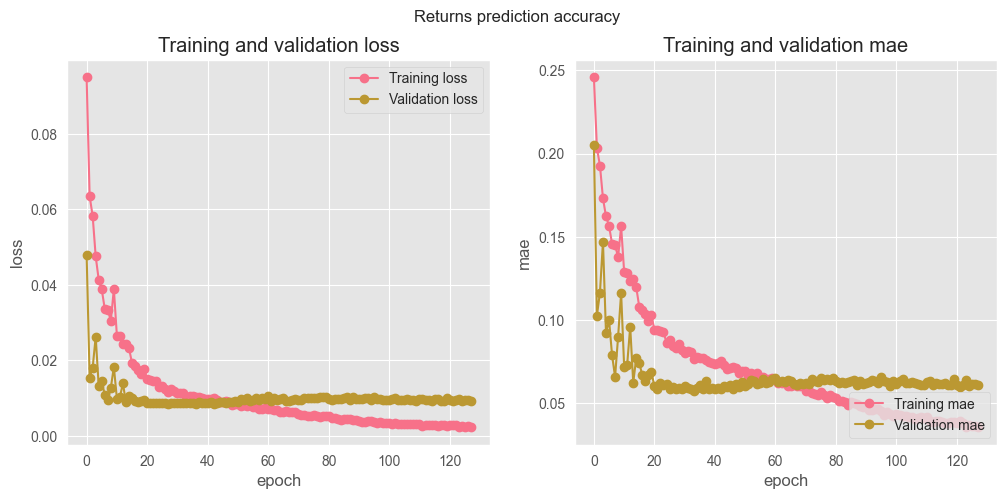

In [ ]:

plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')


In [ ]:
test_pred_Y = m.predict(pp.x_test)
train_pred_Y = m.predict(pp.x_train)

(32, 256)
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step(None, 256)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


plotting returns ( no dependencies)
the model doesnt predict well dat to day log prices



[[1.         0.00135222]
 [0.00135222 1.        ]]
-0.7770524491194131


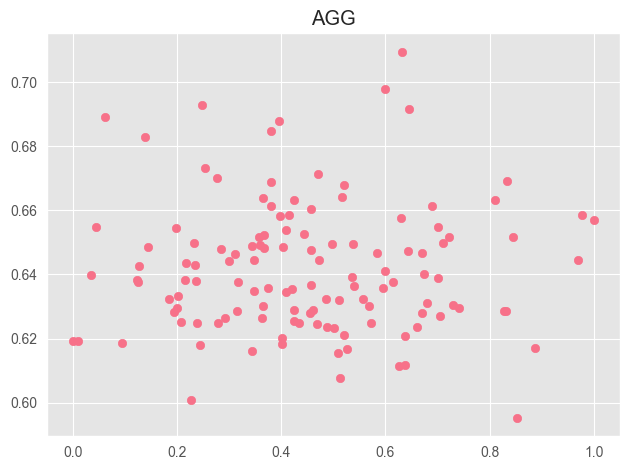

[[ 1.         -0.07879984]
 [-0.07879984  1.        ]]
-2.9012261350049195


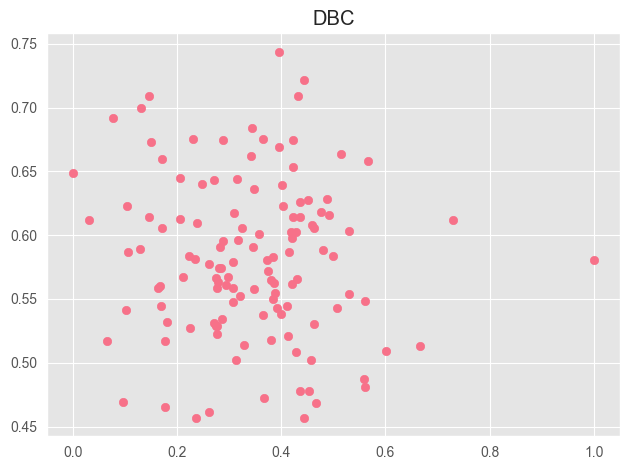

[[1.         0.14434618]
 [0.14434618 1.        ]]
-0.20080884797365695


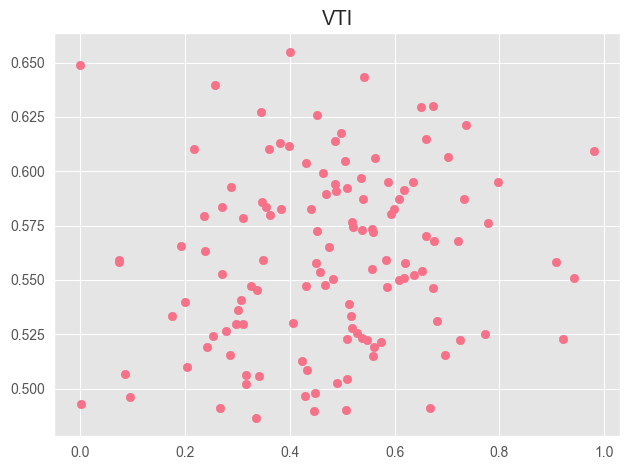

[[1.         0.14266727]
 [0.14266727 1.        ]]
-0.07689013874130857


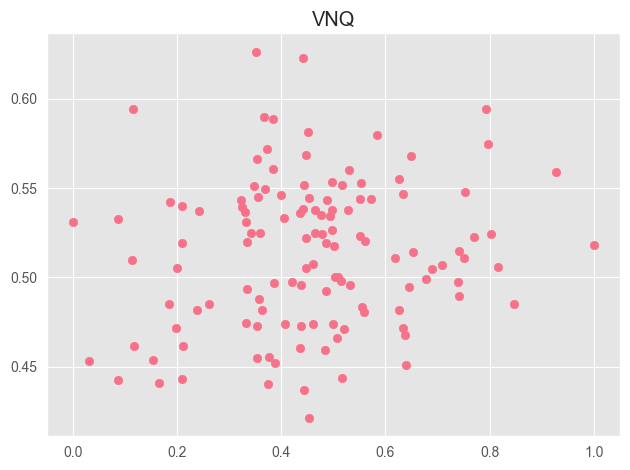

[[ 1.         -0.08152189]
 [-0.08152189  1.        ]]
-0.4444297414716152


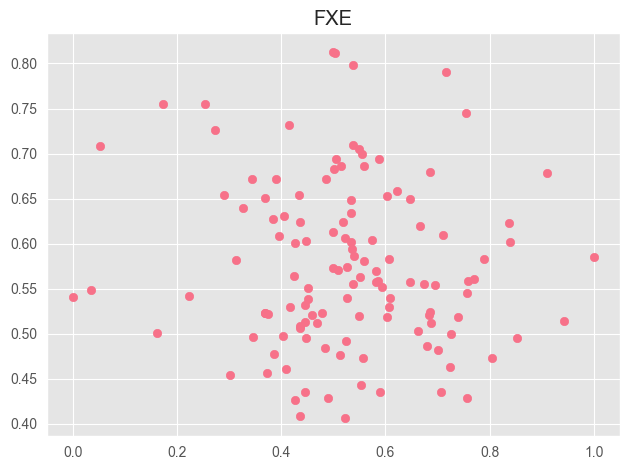

In [ ]:
from sklearn.metrics import r2_score
for i,ticker in enumerate(TICKERS):
    #print(test_Y.shape)
    plt.scatter(pp.y_test[:, i], test_pred_Y[:,i])
    plt.title(ticker)
    plt.tight_layout()
    print(np.corrcoef(pp.y_test[:, i], test_pred_Y[:,i]))
    print(r2_score(pp.y_test[:, i], test_pred_Y[:,i]))
    plt.show()

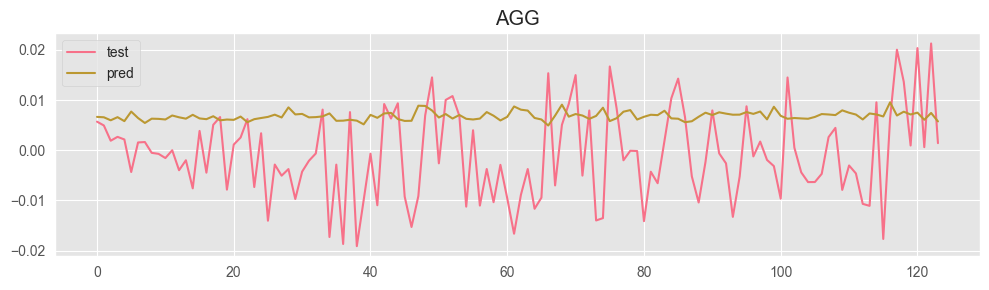

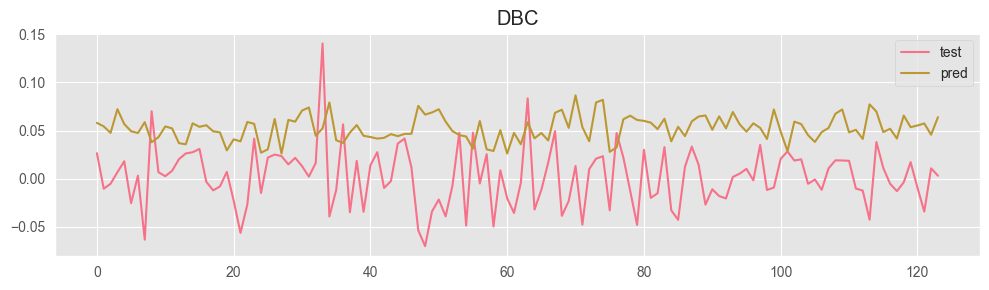

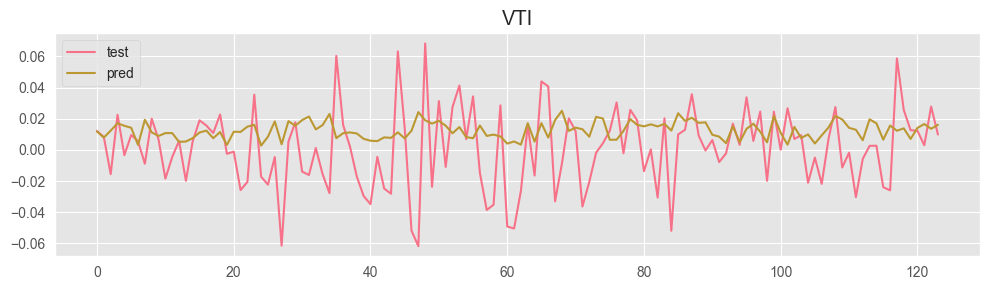

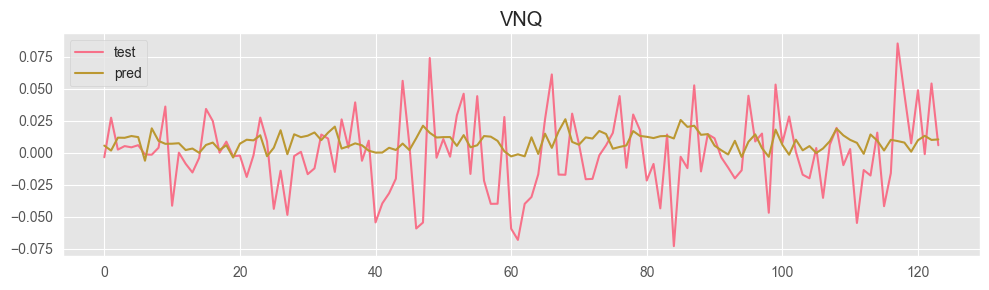

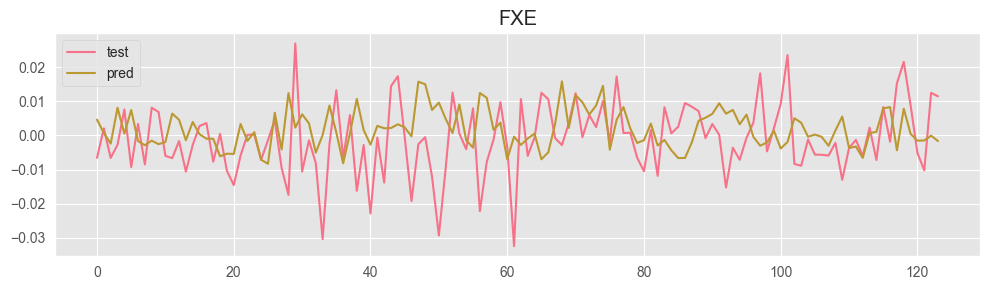

In [ ]:

for i, ticker in enumerate(TICKERS):

    plt.figure(figsize=(10, 3))
    plt.plot(pp.y_scaler_test.inverse_transform(pp.y_test)[:, i])
    plt.plot(pp.y_scaler_test.inverse_transform(test_pred_Y)[:, i])
    plt.legend(["test", 'pred'])
    plt.title(ticker)
    plt.tight_layout()
    plt.show()

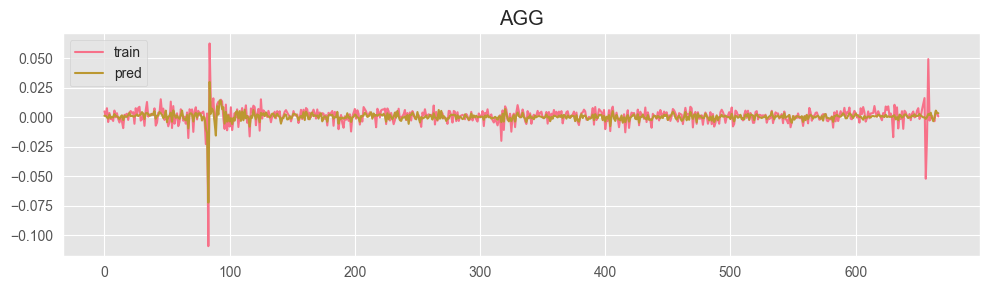

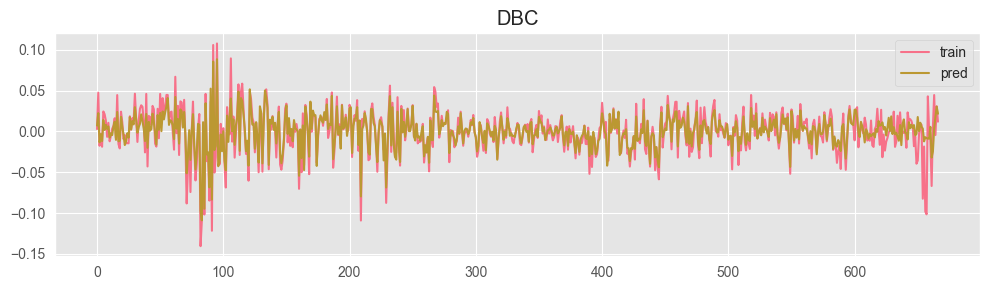

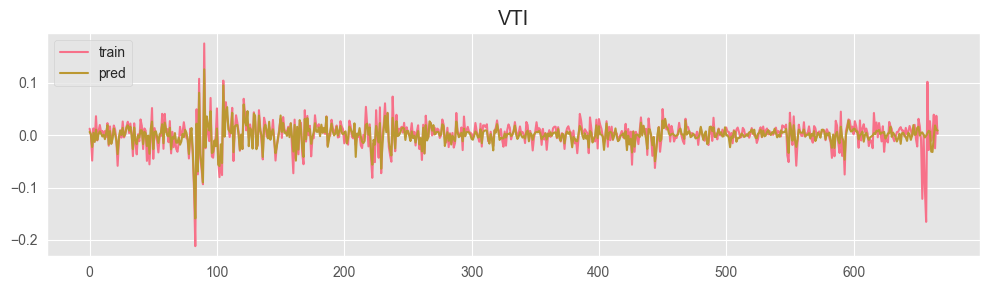

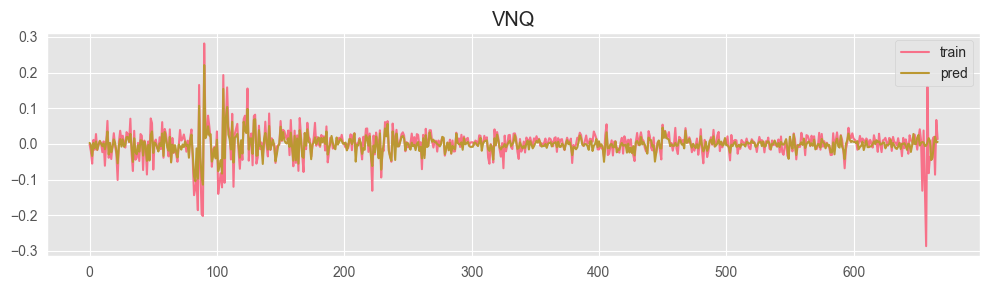

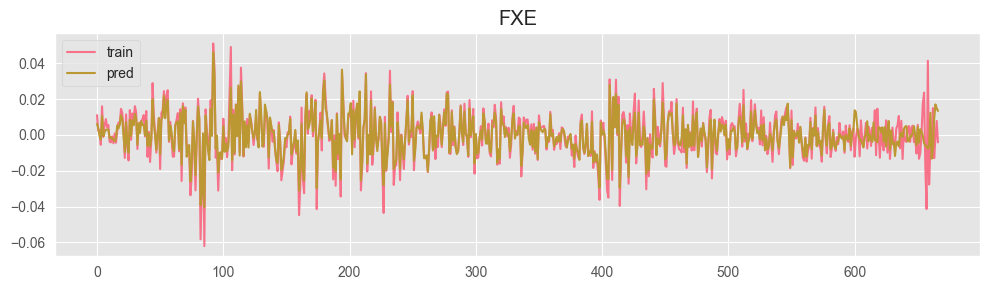

In [ ]:
for i, ticker in enumerate(TICKERS):

    plt.figure(figsize=(10, 3))
    plt.plot(pp.y_scaler_train.inverse_transform(pp.y_train)[:, i])
    plt.plot(pp.y_scaler_train.inverse_transform(train_pred_Y)[:, i])
    plt.legend(["train", 'pred'])
    plt.title(ticker)
    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluation of the model on test data
# Evaluation of the model on test data
scores = m.evaluate(X_test, Y_test, verbose=0)
print(f"MSE: {scores[0]}" )

# Predict train
train_predictions = m.predict(X_train)

train_predictions_scaled = y_scaler_train.inverse_transform(train_predictions)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Predict test
test_predictions = m.predict(X_test)

test_predictions_scaled = y_scaler_test.inverse_transform(test_predictions)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

MSE: 0.058756519109010696
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
### Markowitz Optimisation - Code
from scipy.optimize import Bounds, LinearConstraint
def markowitz_portfolio(returns, cov_matrix, risk_free_rate, initial_weights=None,
                        diversification_penalty_coeff=0.1, deviation_penalty_coeff=0.1,
                        time_window=1):
    """
  Get portfolio weights based on Markowitz model across time. Starts from equal weights.
  Then use previous period weights as a reference point. Time window is the lenght
  of historical data to take into account. It needs to be greater or equal to 1
  so that there are at least 2 observations for covariance
  (at least one history + prediction)
    """
    num_assets = len(returns)
    if initial_weights is None:
        initial_weights = np.array([1 / num_assets] * num_assets)

    # Define constraints (sum of weights equals 1). Commented out set-up is for SLSQP optimizer
    #constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    constraints = LinearConstraint(np.repeat(1, num_assets), [1], [1])
    # Define bounds (weights between 0 and 1)
    #bounds = tuple((0, 1) for asset in range(num_assets))
    bounds = Bounds(np.repeat(0, num_assets), np.repeat(1, num_assets))

    # Define the objective function to minimize
    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
        diversification_penalty = np.sum(weights ** 2)
        deviation_penalty = np.sum((weights - initial_weights) ** 2)

        return (-sharpe_ratio +
                diversification_penalty_coeff * diversification_penalty +
                deviation_penalty_coeff * deviation_penalty)

    # Initialize optimization, need SLSQP or trust-constr given constraints.
    # Trust-constr is slower but results in a better convergence
    result = minimize(negative_sharpe_ratio, initial_weights, method='trust-constr', bounds=bounds,
                      constraints=constraints)

    # Try again with equal weights if optimization fails
    if not result.success:
        result = minimize(negative_sharpe_ratio, np.array([1 / num_assets] * num_assets),
                          method='SLSQP', bounds=bounds,
                          constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    return result.x


def markowitz_weights(Y_realised, Y_predictions, risk_free_rates=0.02, time_window=1,
                      average_return_with_history=True,  # take an average over prediction plus history in Markowitz
                      diversification_penalty_coeff=0.1, deviation_penalty_coeff=0.1):
    """
    Get portfolio weights based on Markowitz model across time. Starts from equal weights.
    Time window is the length of historical data to take into account. It needs to
    be greater or equal to 1 so that there are at least 2 observations for covariance
    (at least one history + prediction)
    """
    starting_weights = np.array([1.0 / len(TICKERS)] * len(TICKERS))
    all_weights = None
    for i in range(time_window, len(Y_realised)):
        ret_sequence = np.vstack([Y_realised[i - time_window: i], Y_predictions[i]])
        ret_sequence = np.exp(ret_sequence) - 1  # Transform log returns to returns
        if average_return_with_history:
            mean_returns = np.mean(ret_sequence, axis=0)
        else:
            mean_returns = np.exp(Y_predictions[i]) - 1
        cov_matrix = np.cov(ret_sequence, rowvar=False)

        # Time-varying RF rate if provided, otherwise constant
        risk_free_rate = risk_free_rates[i] if len(risk_free_rates) > 1 else risk_free_rates

        weights = markowitz_portfolio(mean_returns, cov_matrix, risk_free_rate,
                                      initial_weights=starting_weights,
                                      diversification_penalty_coeff=diversification_penalty_coeff,
                                      deviation_penalty_coeff=deviation_penalty_coeff,
                                      time_window=time_window)
        all_weights = np.vstack([all_weights, weights]) if all_weights is not None else np.array([weights])

        # Use previous weights as a starting point for next optimization
        starting_weights = weights

    return all_weights


def plot_portfolio_weights(weights):
    """
    Plot portfolio weights. USes constants defined top of this notebook as labels
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(weights.shape[0])

    for i in range(weights.shape[1]):
        ax.bar(range(weights.shape[0]), weights[:, i], label=TICKERS[i], bottom=bottom, edgecolor="none")
        bottom += weights[:, i]

    ax.set_xlabel('Time')
    ax.set_ylabel('Weights')
    ax.set_title('Portfolio Weights Over Time')
    ax.legend()
    ax.grid(True)
    plt.show()


def calculate_and_plot_returns_v2(returns_data, weights1, weights2,
                               label1='Model1 Strategy', label2='Equal Weights',
                               plot_title='Test returns', time_axis=None,
                               return_df=False):
  """
  Calculate within period portfolio log returns and aggregated returns.
  Plot only, or plot and output a dataframe with results.
  Assumes we want our strategy and a benchmark strategy.
  Time axis is optional.
  """
  portfolio_log_returns = (weights1 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)
  portfolio_log_returns2 = (weights2 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)

  # Cumulative log returns
  cumulative_portfolio_log_return = np.cumsum(portfolio_log_returns)
  cumulative_portfolio_log_return2 = np.cumsum(portfolio_log_returns2)

  # Normal returns?
  cumulative_portfolio_return = np.exp(cumulative_portfolio_log_return) - 1
  cumulative_portfolio_return2 = np.exp(cumulative_portfolio_log_return2) - 1

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(cumulative_portfolio_log_return, label=label1)
  ax1.plot(cumulative_portfolio_log_return2, label=label2)
  ax1.set_title('Cumulative log returns')
  ax1.set_ylabel('Cumulative log returns')
  ax1.set_xlabel('Time')
  ax1.legend(loc='upper right')

  ax2.plot(cumulative_portfolio_return, label=label1)
  ax2.plot(cumulative_portfolio_return2, label=label2)
  ax2.set_title('Cumulative returns')
  ax2.set_ylabel('Cumulative returns')
  ax2.set_xlabel('Time')
  ax2.legend(loc='upper right')
  f.suptitle(plot_title)

  output = {
      label1 + ' Log Return': portfolio_log_returns,
      label2 + ' Log Return': portfolio_log_returns2,
      label1 + ' Cumulative Log Return': cumulative_portfolio_log_return,
      label2 + ' Cumulative Log Return': cumulative_portfolio_log_return2,
      label1 + ' Cumulative Return': cumulative_portfolio_return,
      label2 + ' Cumulative Return': cumulative_portfolio_return2,
    }
  if time_axis is not None:
    output['Date'] = time_axis[MARKOWITZ_TIME_WINDOW:]

  if return_df:
    return pd.DataFrame(output)
  else:
    return


def calculate_and_plot_returns(returns_data, weights1, weights2,
                               label1='Model1 Strategy', label2='Equal Weights',
                               plot_title='Test returns'):
    portfolio_log_returns = (weights1 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)
    portfolio_log_returns2 = (weights2 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)

    # Cumulative log returns
    cumulative_portfolio_log_return = np.cumsum(portfolio_log_returns)
    cumulative_portfolio_log_return2 = np.cumsum(portfolio_log_returns2)

    # Normal returns?
    cumulative_portfolio_return = np.exp(cumulative_portfolio_log_return) - 1
    cumulative_portfolio_return2 = np.exp(cumulative_portfolio_log_return2) - 1

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(cumulative_portfolio_log_return, label=label1)
    ax1.plot(cumulative_portfolio_log_return2, label=label2)
    ax1.set_title('Cumulative log returns')
    ax1.set_ylabel('Cumulative log returns')
    ax1.set_xlabel('Time')
    ax1.legend(loc='upper right')

    ax2.plot(cumulative_portfolio_return, label=label1)
    ax2.plot(cumulative_portfolio_return2, label=label2)
    ax2.set_title('Cumulative returns')
    ax2.set_ylabel('Cumulative returns')
    ax2.set_xlabel('Time')
    ax2.legend(loc='upper right')
    f.suptitle(plot_title)
    return cumulative_portfolio_return, cumulative_portfolio_return2

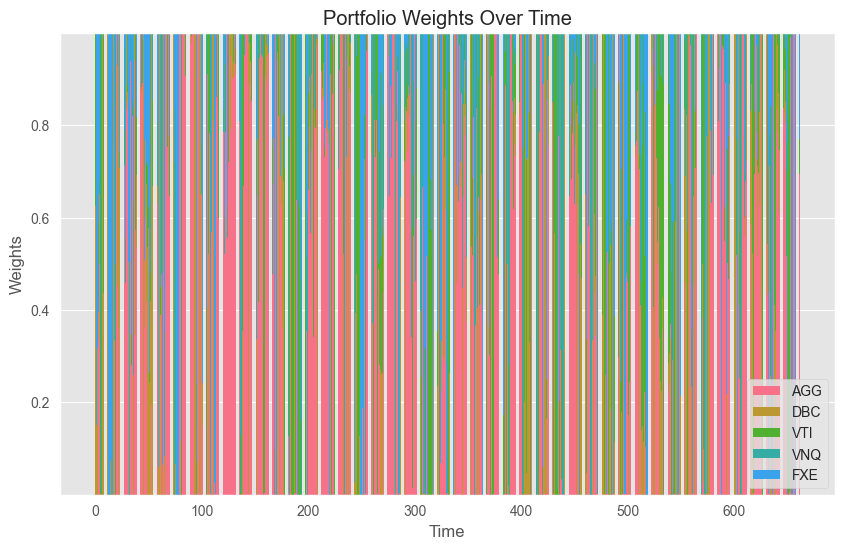

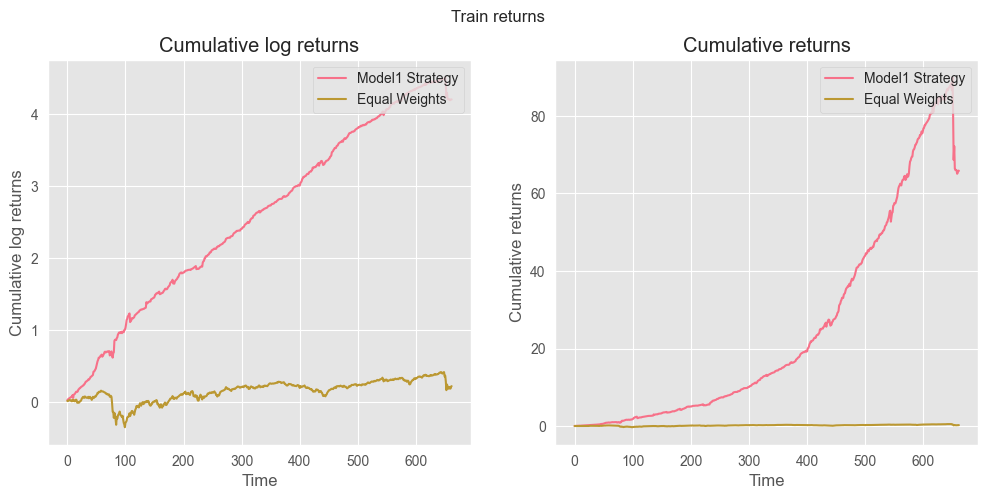

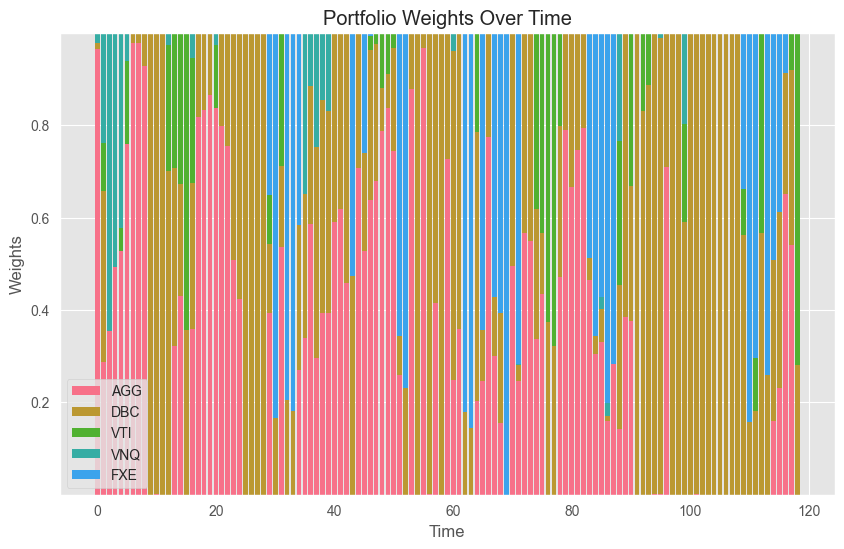

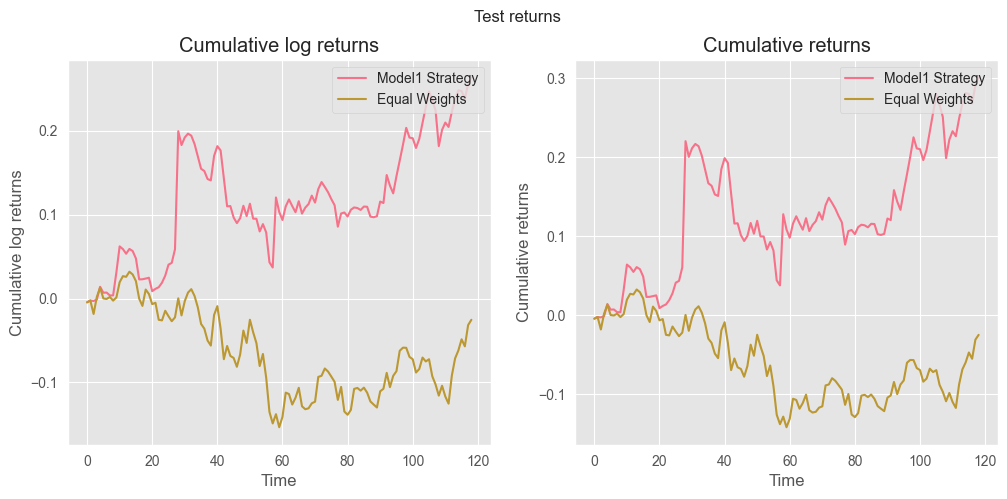

In [ ]:
import warnings
TIME_STEP=50
test_date_index = pp.history_test_df[TIME_STEP:].index
train_date_index = pp.history_train_df[TIME_STEP:].index




warnings.filterwarnings("ignore")
#### Markowitz Portfolio
# time window to consider in cov matrix, and to calculate an average for E(R)
# if average_return_with_history is set to true
MARKOWITZ_TIME_WINDOW = 5
# Create equal weights portfolio to serve as a performance benchmark (a naive model)
equal_weights_test = np.array([np.repeat(1 / len(TICKERS), len(TICKERS)) for _ in
                               range(Y_test_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])

equal_weights_train = np.array([np.repeat(1 / len(TICKERS), len(TICKERS)) for _ in
                                range(Y_train_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])

# Divide by 52 to make the annual RF rate weekly
risk_free_train = pp.risk_free_train['fedfunds'] / (100 * 52)
risk_free_test = pp.risk_free_test['fedfunds'] / (100 * 52)
# Silence (BUT TO DO - CHECK AND JUSTIFY) - running many optimizations and some of them show this warning
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
train_weights = markowitz_weights(Y_train_scaled, train_predictions_scaled,
                                  average_return_with_history=False,
                                  risk_free_rates=risk_free_train,  # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(train_weights)

train_ret_df = calculate_and_plot_returns_v2(Y_train_scaled, train_weights, equal_weights_train,
                                          plot_title='Train returns',
                                          time_axis=train_date_index, return_df=True)

#calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train, plot_title='Train returns')
MARKOWITZ_TIME_WINDOW = 5
test_weights = markowitz_weights(Y_test_scaled, test_predictions_scaled,
                                 average_return_with_history=False,
                                 risk_free_rates=risk_free_test,  # RF rate is annual, make it weekly
                                 time_window=MARKOWITZ_TIME_WINDOW,
                                 diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                 )
plot_portfolio_weights(test_weights)

test_ret_df = calculate_and_plot_returns_v2(Y_test_scaled, test_weights, equal_weights_test,
                                          plot_title='Test returns',
                                          time_axis=test_date_index, return_df=True)

#calculate_and_plot_returns(Y_test_scaled, test_weights, equal_weights_test, plot_title='Test returns')

In [ ]:
train_ret_df.to_csv('CNN_BILSTM_ECA_Train.csv')
test_ret_df.to_csv('CNN_BILSTM_ECA_Test.csv')

In [ ]:
!pip install lime
from lime import explanation
from lime import lime_base

(5000, 256)


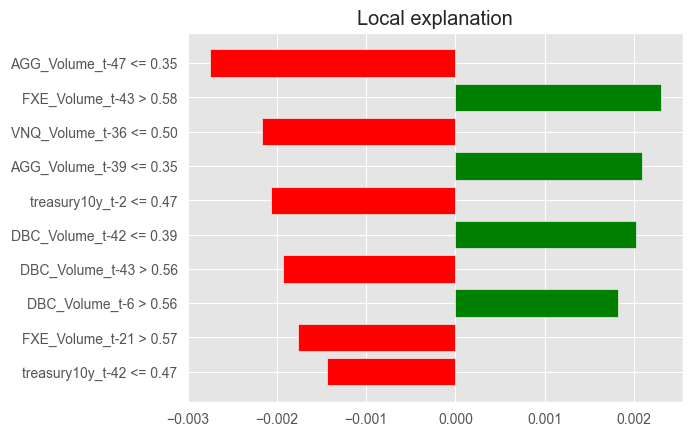

(5000, 256)


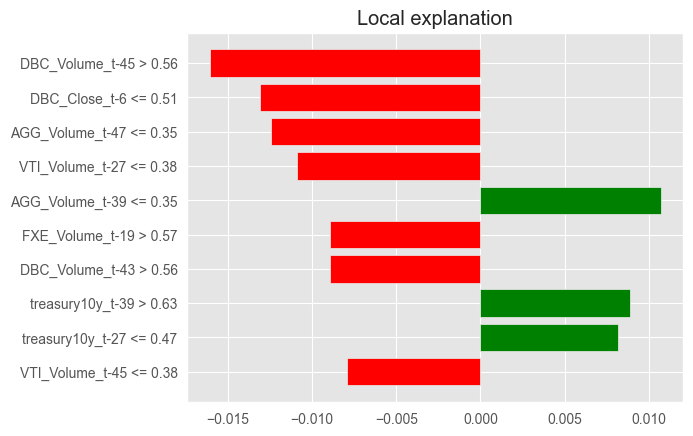

(5000, 256)


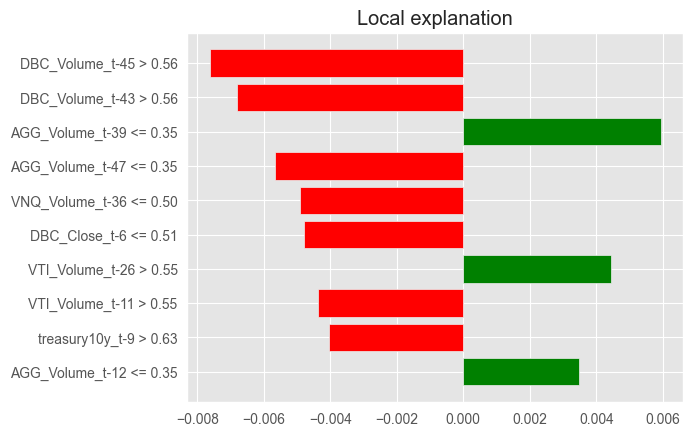

(5000, 256)


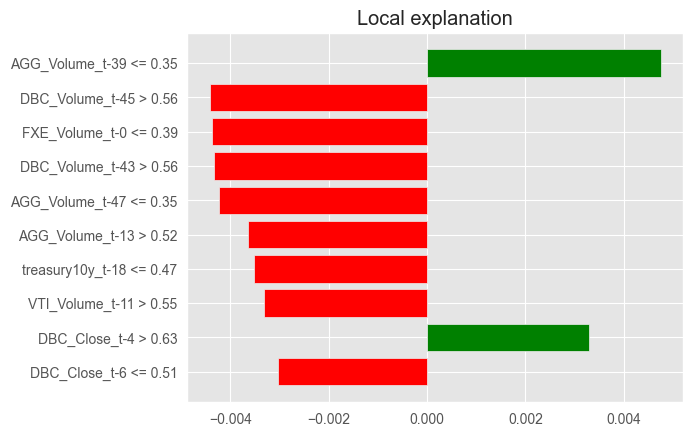

(5000, 256)


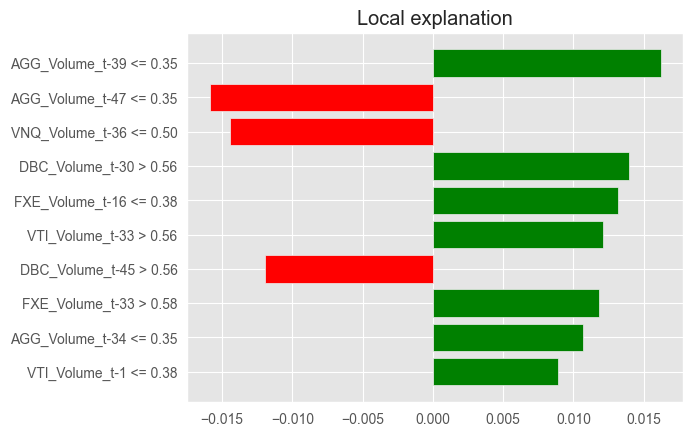

In [ ]:
from lime import explanation
from lime import lime_base
from lime.lime_tabular import RecurrentTabularExplainer


# this is used for probabilities, but our data is normalised, so we use this to explain
for i in range(5):
  idx = 81 # explained instance
  num_features = 5 # how many feature contained in explanation
  num_slices = 24 # split time series
  series = X_train[idx, :]
  explainer = RecurrentTabularExplainer(X_train, mode='regression', feature_names=pp.history_train_df.columns)
  exp = explainer.explain_instance(series, lambda x: m(x).numpy().reshape(-1,5)[:,i])
  exp.as_pyplot_figure()
  plt.show()